# Reattachment of Cargo

This closesly mirrors the main results for figure 7. Here, instead of modulating the detachment rates to meet demand, the detachment rates are equal and uniform in all compartments (as are the trafficking rates). The reattachment rates are modified to be inversely proportional to the demand signal.

In [1]:
from __future__ import division
import numpy as np
from scipy.integrate import odeint
from scipy.linalg import expm # matrix exponential solves linear system
import matplotlib.pyplot as plt
from time import sleep
%matplotlib inline

In [2]:
# JSAnimation import available at https://github.com/jakevdp/JSAnimation
from JSAnimation import IPython_display
from matplotlib import animation

N = 100 # number of compartments
x = np.linspace(0,1,N) # position along cable
DC = 10 # diffusion coeff [microns^2 s^-1]
CS = 8  # microns

def get_target_profile(n_syn,syn_loc=None):
    # Calculate target profile, y
    if syn_loc is None: syn_loc = np.linspace(0.1,0.9,n_syn)
    x = np.linspace(0,1,N)
    y = np.zeros(N)
    for i in syn_loc:
        y += 0.5*np.exp(-abs(x - x[int(i*N)])*100)
    return y

def get_matrix(y,c_scale,d_scale,bias=0.0):
    """Calculates the state-transition matrix, A"""
    
    # detachment rates
    c = c_scale*np.ones(N)
    
    # reattachment rates
    d = d_scale/y
    
    # trafficking rates, constrain so that a+b = DC/2
    a = np.linspace((DC/(CS**2)/2.)+bias,(DC/(CS**2)/2.),N-1)
    b = np.linspace((DC/(CS**2)/2.)-bias,(DC/(CS**2)/2.),N-1)
    
    # State-transition matrix:
    # 
    # A = [ A1 | A2
    #       A3 | A4 ]
    mid = -c
    mid[:-1] -= a
    mid[1:]  -= b
    A1 = np.diag(a, -1) + np.diag(mid) + np.diag(b, 1) # movement on microtubules, detaching cargo lost
    A2 = np.diag(d) # reattaching cargo recieved at microtubules
    A3 = np.diag(c) # detaching cargo recieved at synapses
    A4 = -np.diag(d) # reattaching cargo lost at synapses 
    
    # State-transition matrix
    A = np.array(np.bmat([[A1,A2],[A3,A4]]))
    
    # initial condition
    u0 = np.zeros(2*N)
    u0[0] = np.sum(y)
    
    return A,u0

def sim(cs,ds,t,n_syn=6,bias=0.0):
    y = get_target_profile(n_syn)#np.ones(N)/N
    A,u0 = get_matrix(y,cs,ds,bias)
    
    # animation figure
    fig = plt.figure()
    ax1 = plt.subplot(2,1,1)
    plt.title('concentration on microtubule')
    line1, = ax1.plot([],[],lw=2)
    plt.ylim([-0.02,0.2]),plt.xlim([0,1])
    ax2 = plt.subplot(2,1,2)
    plt.title('detached concentration')
    line2, = ax2.plot([],[],lw=2)
    plt.ylim([-0.02,1.0]),plt.xlim([0,1])
    plt.tight_layout()

    def init():
        line1.set_data(x, u0[:N])
        line2.set_data(x, u0[N:])
        return line1,line2,

    def animate(i):
        u = np.dot(expm(A*t[i]),u0)
        line1.set_data(x, u[:N])
        line2.set_data(x, u[N:])
        ax1.set_title('concentration on microtubule: '+str(np.round(t[i]/60))+' mins')
        ax2.set_title('detached concentration: '+str(np.round(100*np.sum(u[N:])/np.sum(u),2))+'% detached')
        return line1,line2,
        
    return fig,animate,init

def calc_tradeoff_curve(y,cs):
    tau,excess = [],[]
    for ds in np.logspace(-4,2,20)[::-1]:
        A,u0 = get_matrix(y,cs,ds*cs)
        tss,uss = calc_time_to_ss(A)
        uss = np.dot(expm(A*10*tss),u0) # steady-state profile
        if np.sum(uss[:N])/np.sum(uss) < 0.01: break
        excess.append(np.sum(uss[:N])/np.sum(uss))
        tau.append(tss)
    return np.array(tau),np.array(excess)

def calc_time_to_ss(A,ss_tol=1e-6,bound_tol=1.0):
    # calculate number of seconds to reach steady-state (within tol)
    u0 = np.ones(N*2)
    u0[0] = 1.0
    
    tt = 1.0
    u = np.dot(expm(A*tt),u0)
    upper_bound,lower_bound = 1e10,0.0
    while (upper_bound - lower_bound) > bound_tol:
        tt = lower_bound + (upper_bound-lower_bound)/2
        u = np.dot(expm(A*tt),u0)
        if np.linalg.norm(np.dot(A,u))/np.sqrt(N) > ss_tol:
            # not converged to steady-state
            lower_bound = tt
        else:
            # converged to steady-state
            upper_bound = tt
    tss = lower_bound + (upper_bound-lower_bound)/2
    return tss,np.dot(expm(A*tss*10),u0)

def err_vs_time(cs,ds,n_syn=6,bias=0.0,tmax=5.5):
    y = get_target_profile(n_syn)#np.ones(N)/N
    A,u0 = get_matrix(y,cs,ds,bias)
    u0[1] = 1.0
    uss = np.dot(expm(A*(10**(tmax+1))),u0)
    t = np.logspace(1.5,tmax,tmax*6)
    err,excess = [],[] 
    for tt in t:
        u = np.dot(expm(A*tt),u0)
        #err.append(np.mean( 100*np.abs(u[N:]-uss[N:])/u[N:] ))
        err.append( 100*np.mean( np.abs(u[N:]-uss[N:])/uss[N:]) )
        excess.append( 100*np.sum(u[:N])/np.sum(u) )
    return t,err,excess

## Reattachment and detachment on comparable timescales: quick convergence, but excess cargo


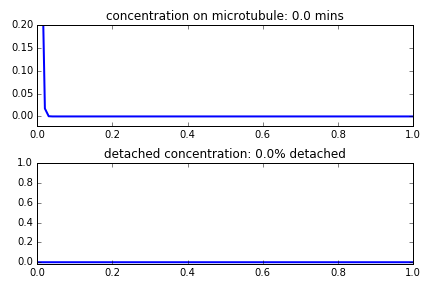
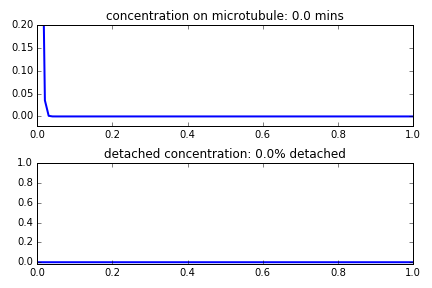
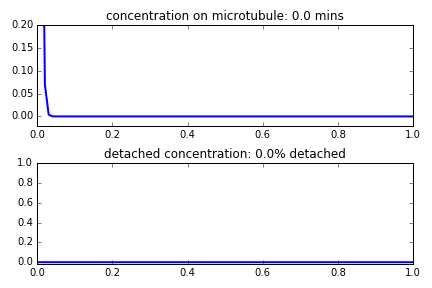
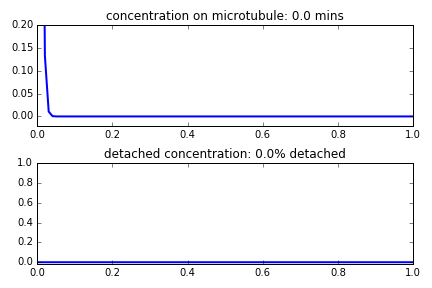
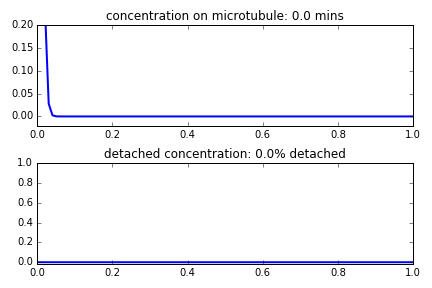
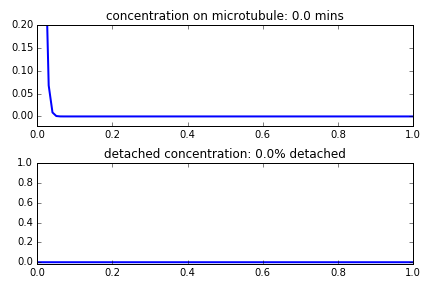
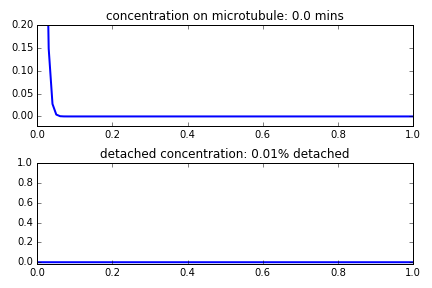
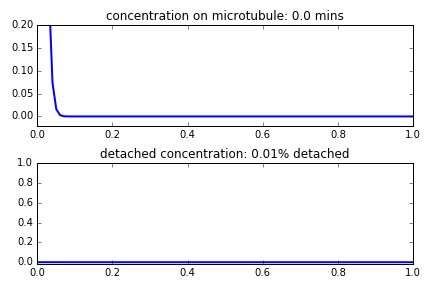
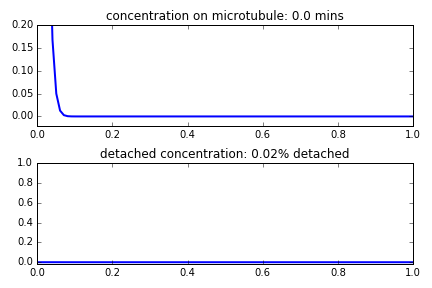
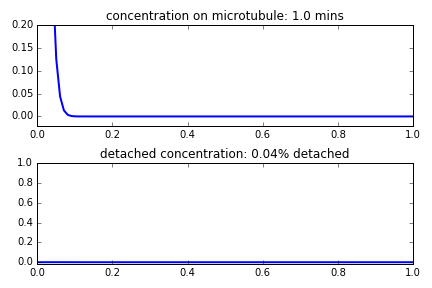
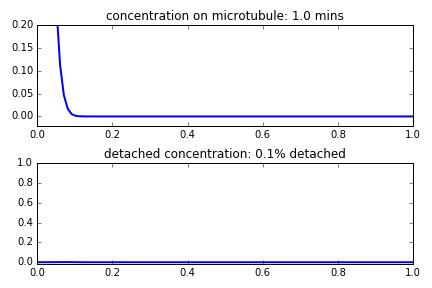
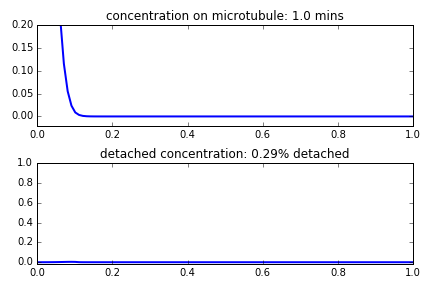
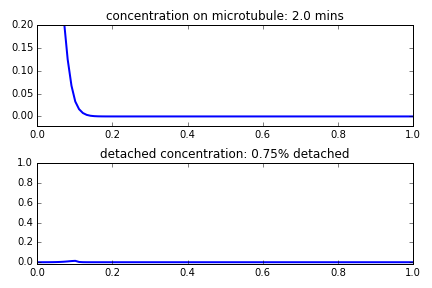
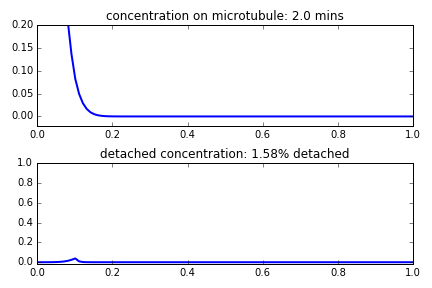
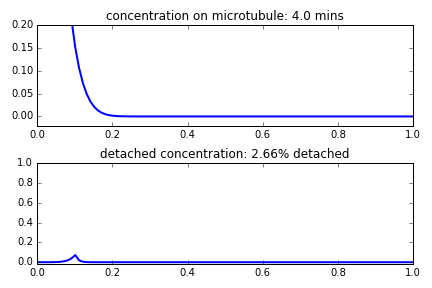
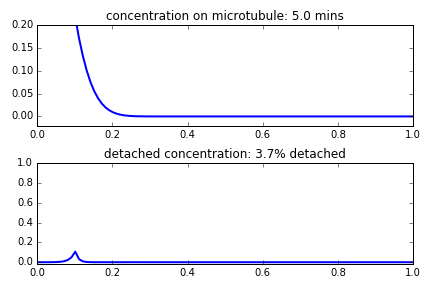
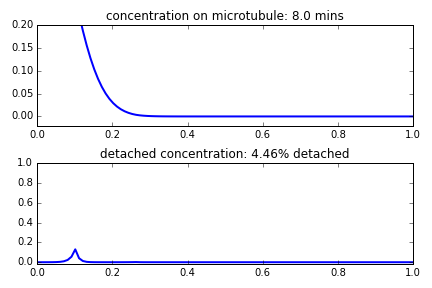
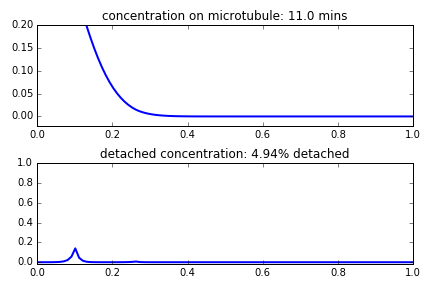
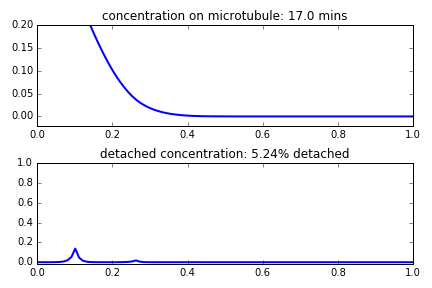
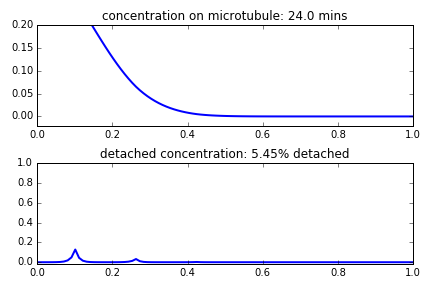
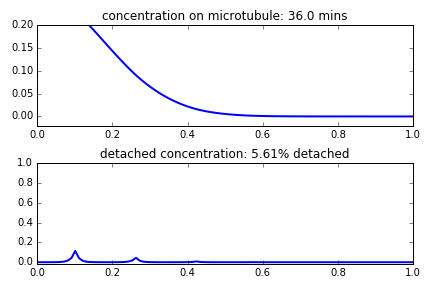
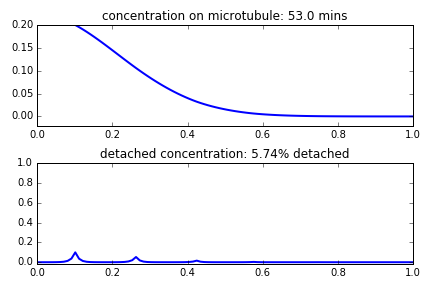
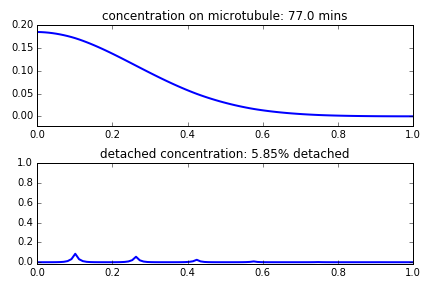
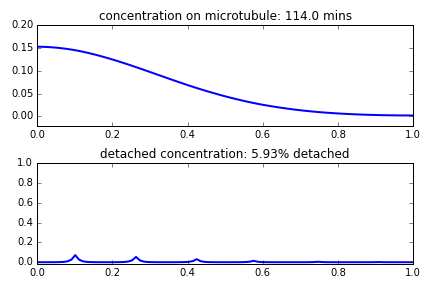
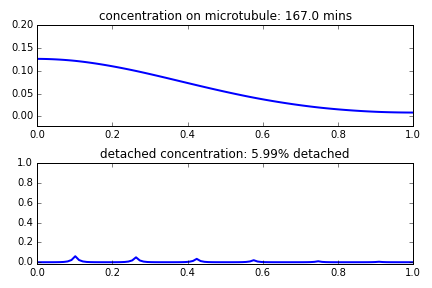
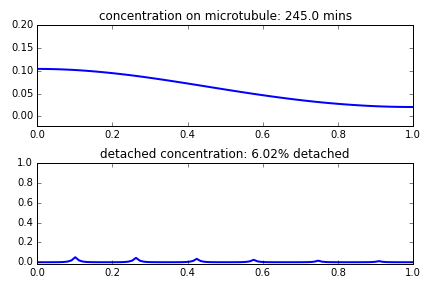
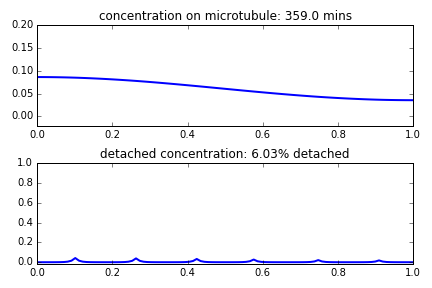
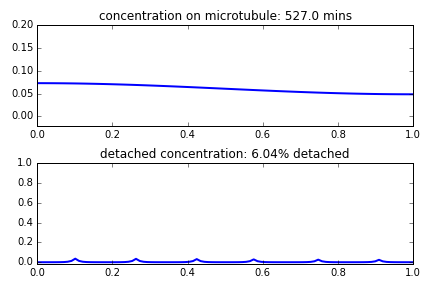
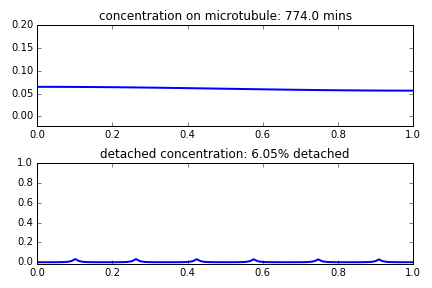
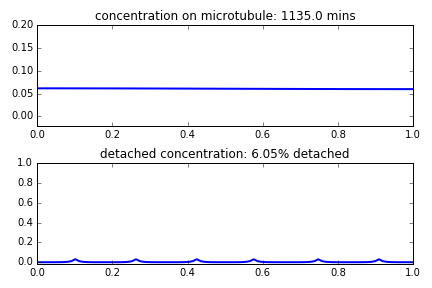
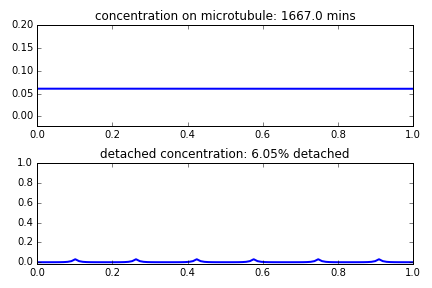
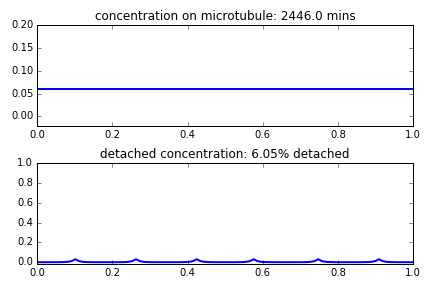
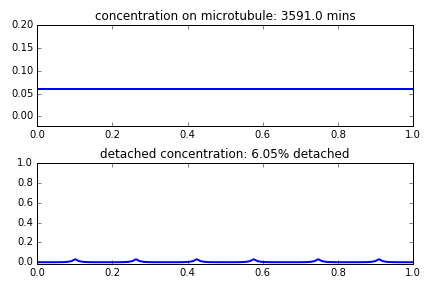
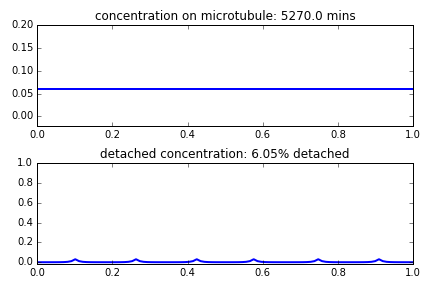
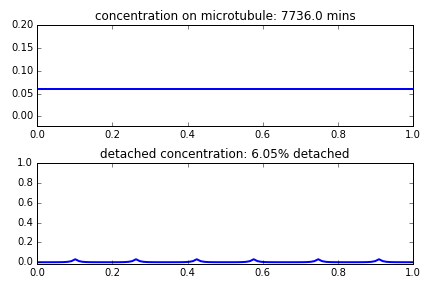
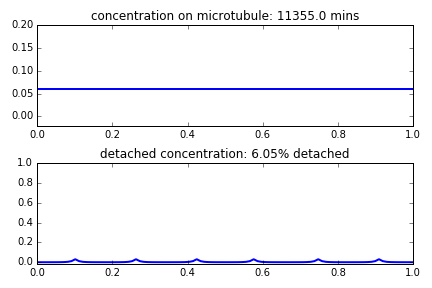
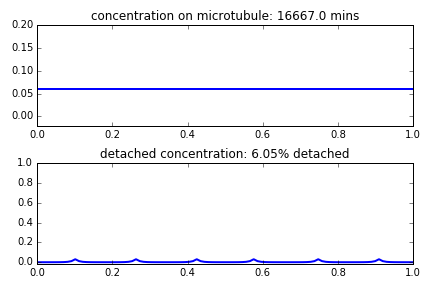
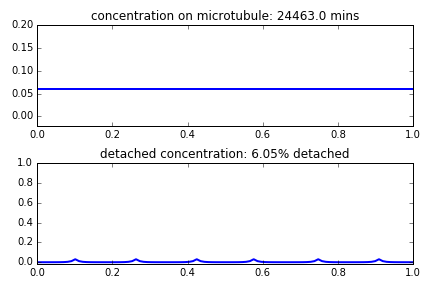
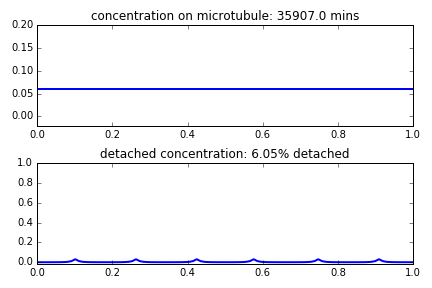
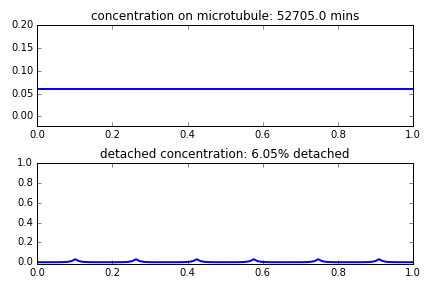

In [3]:
nt = 40
fig,animate,init = sim(1e-1,1e-1,np.logspace(0,6.5,nt))
ani1 = animation.FuncAnimation(fig, animate, init_func=init, frames=nt, interval=100)
ani1

## Detachment faster than reattachment: little excess cargo, slow convergence


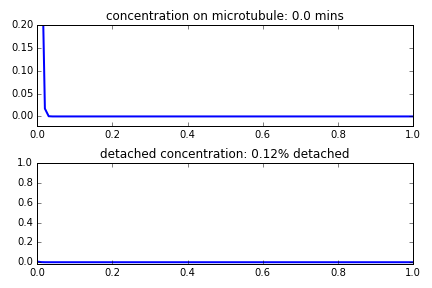
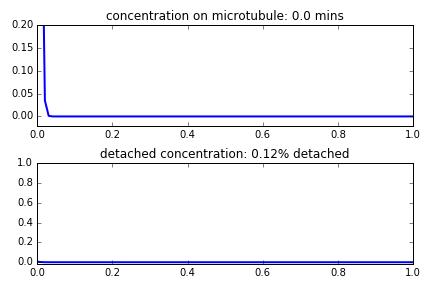
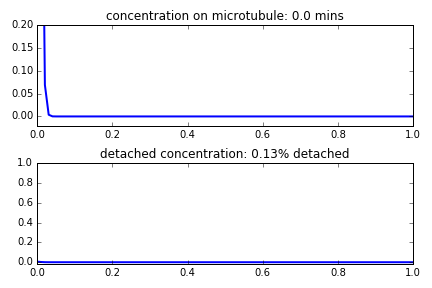
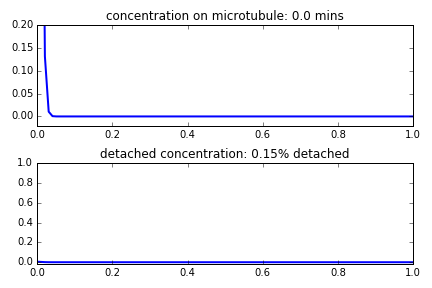
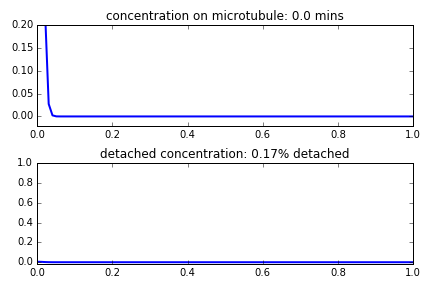
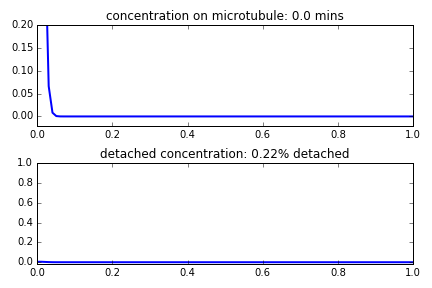
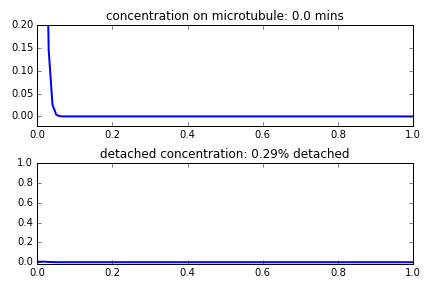
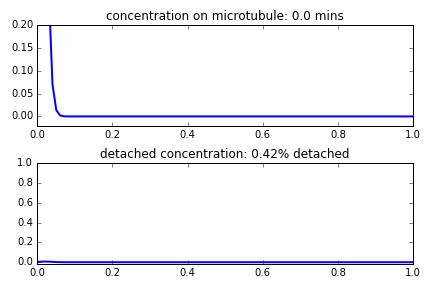
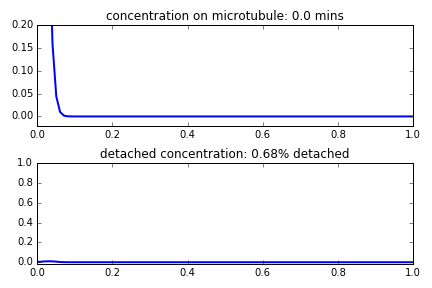
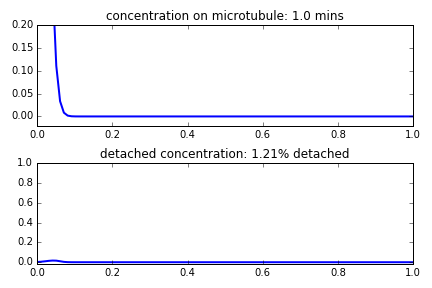
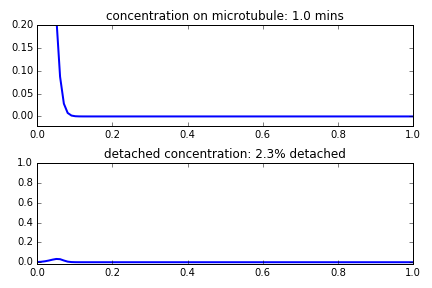
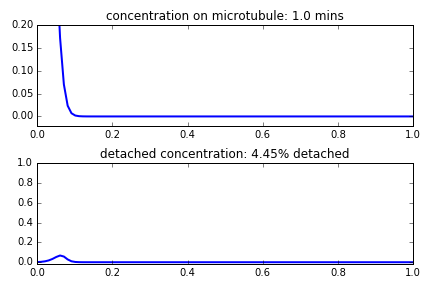
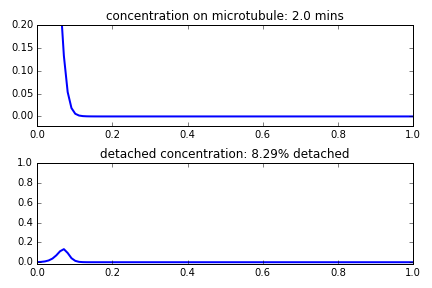
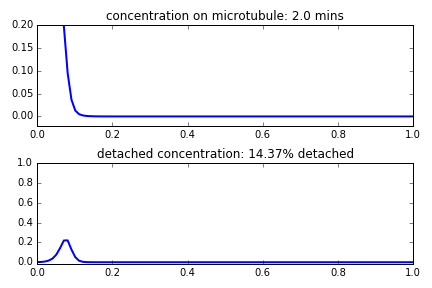
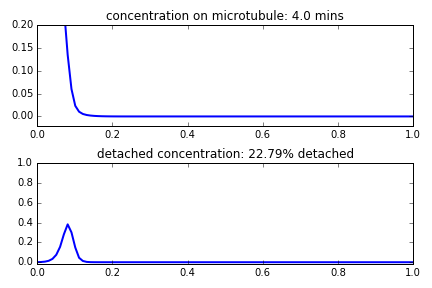
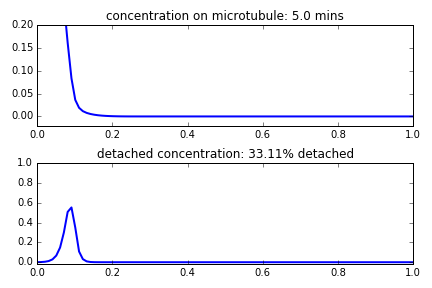
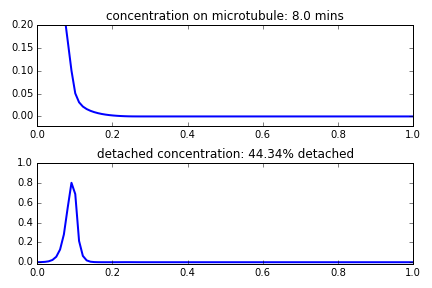
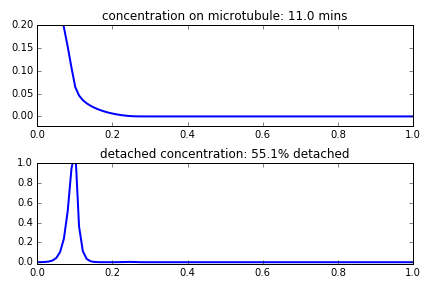
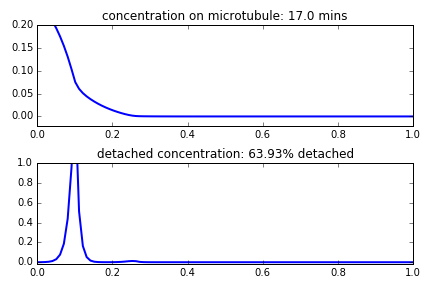
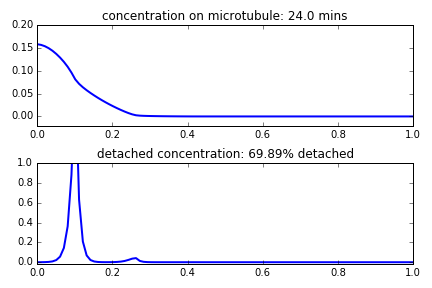
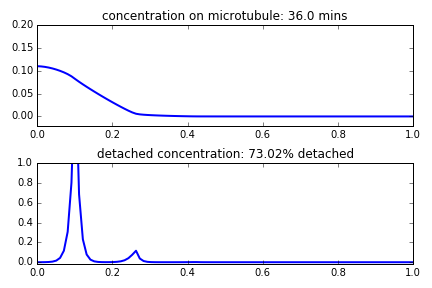
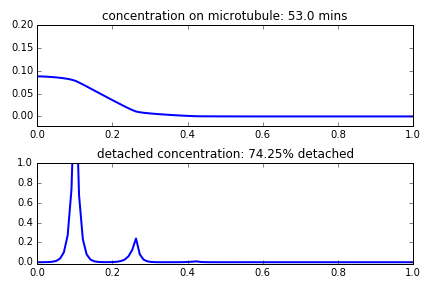
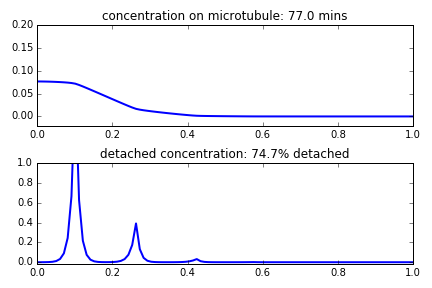
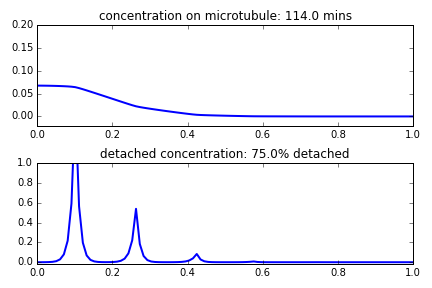
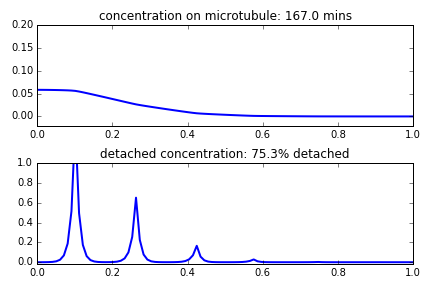
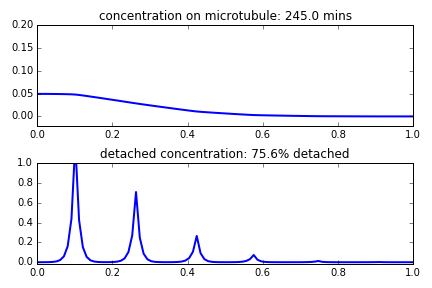
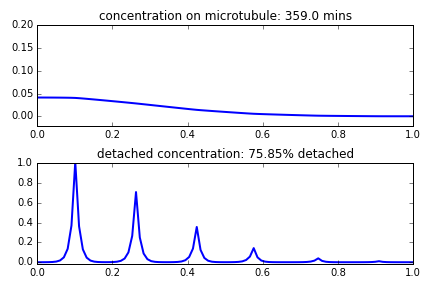
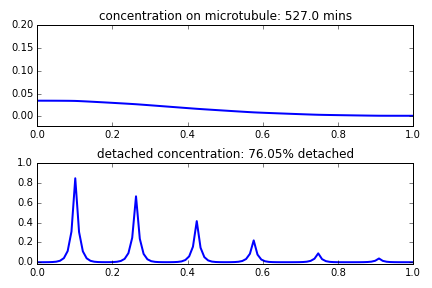
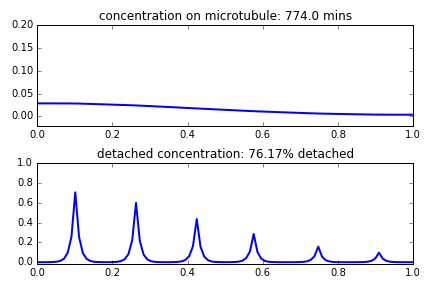
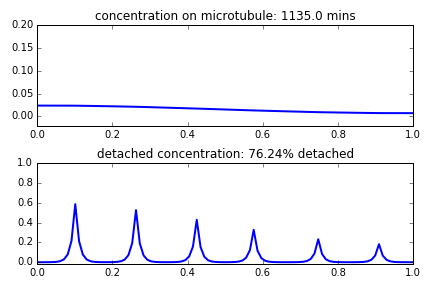
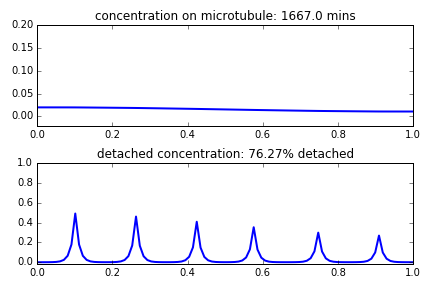
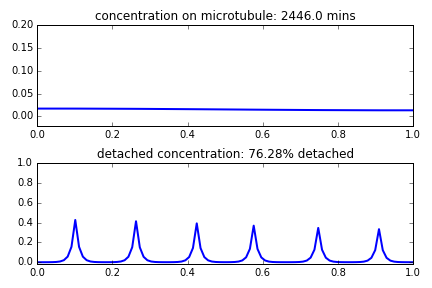
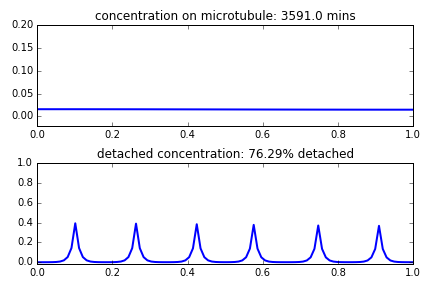
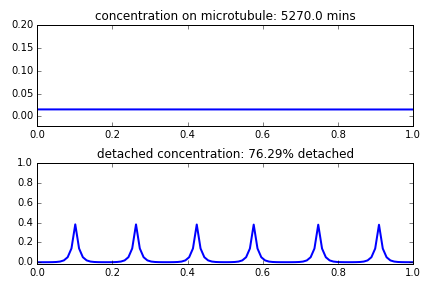
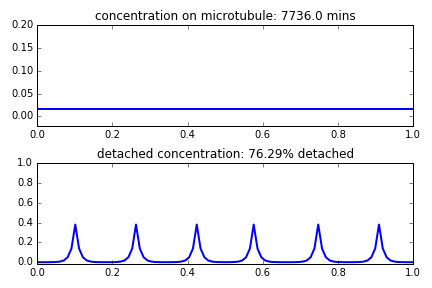
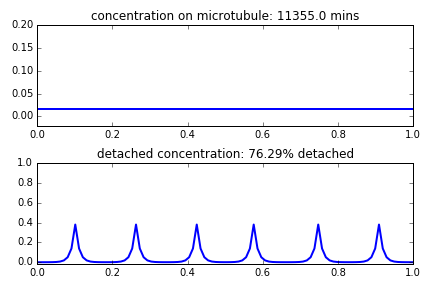
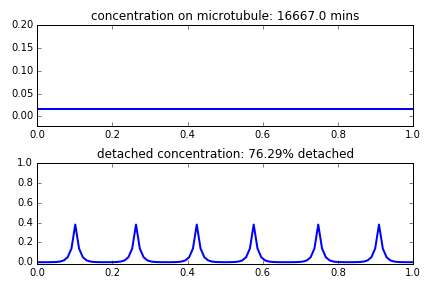
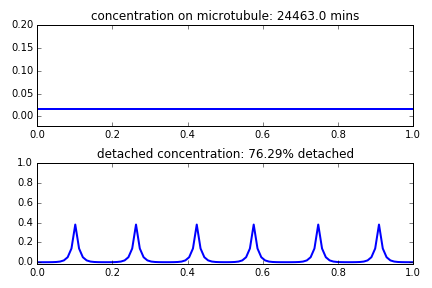
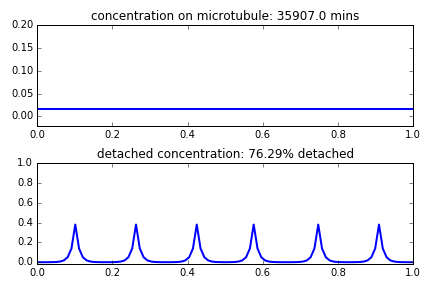
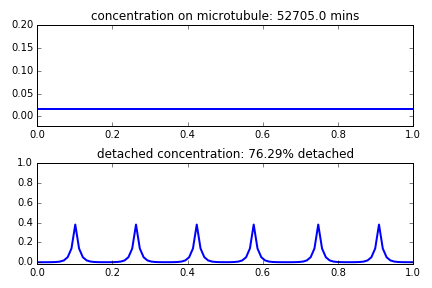

In [4]:
# fast detachment, slow reattachment
fig,animate,init = sim(1e-1,2e-3,np.logspace(0,6.5,nt))
ani2 = animation.FuncAnimation(fig, animate, init_func=init, frames=nt, interval=100)
ani2

## Slow detachment, slower reattachment: little excess cargo, slow convergence (similar to results in Fig. 5-6)


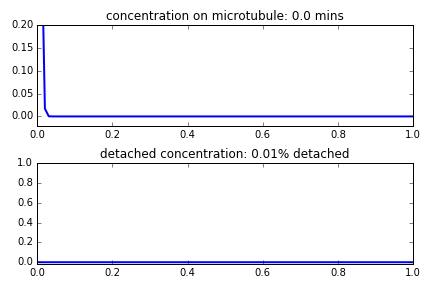
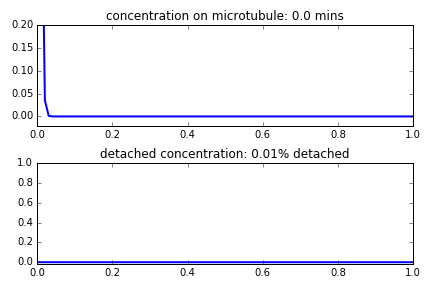
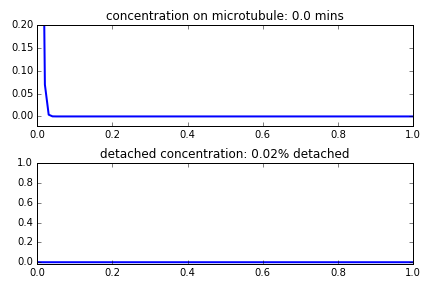
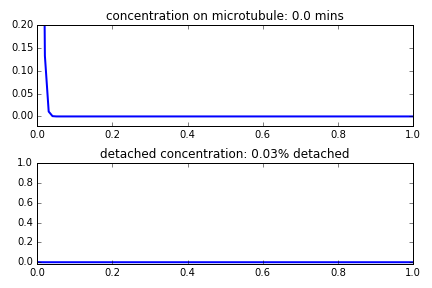
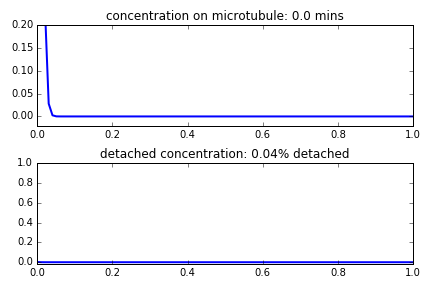
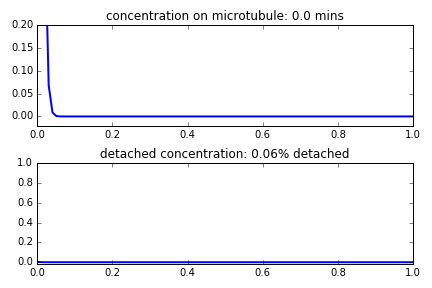
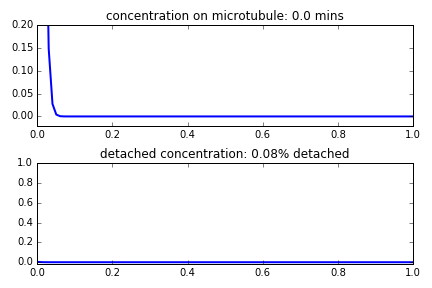
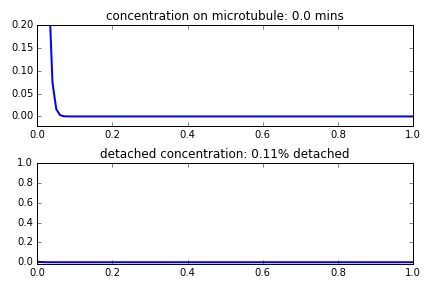
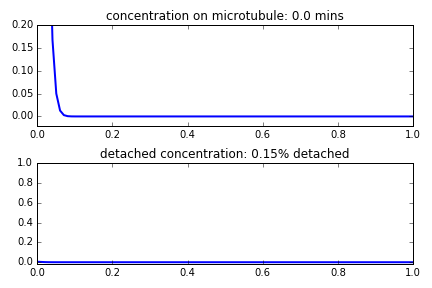
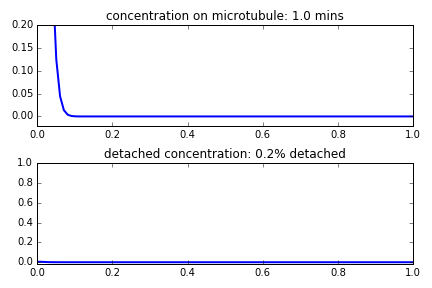
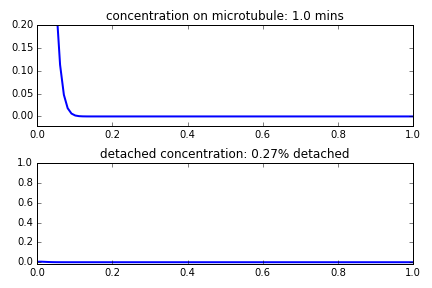
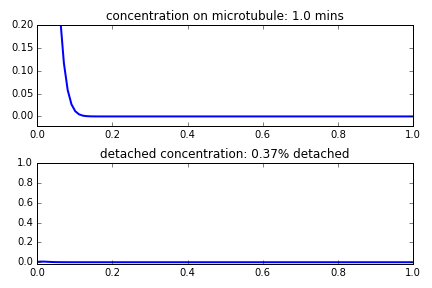
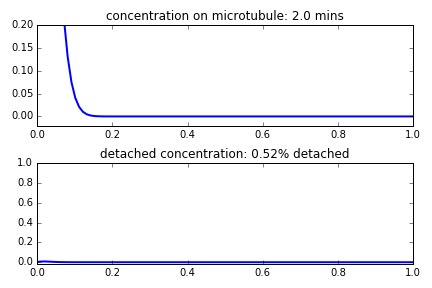
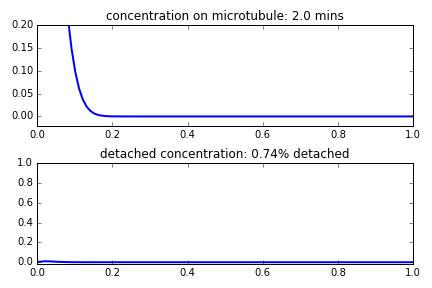
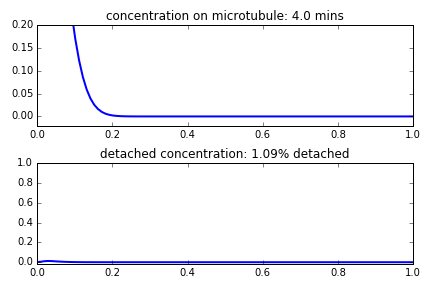
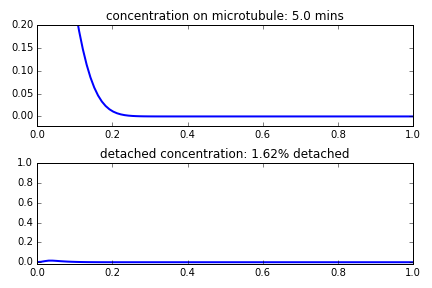
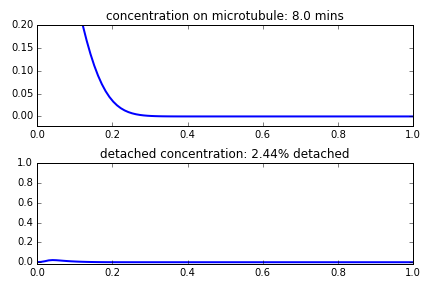
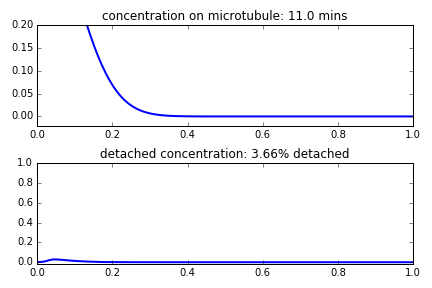
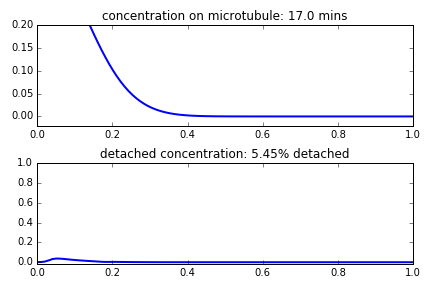
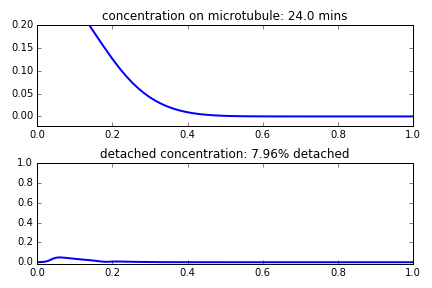
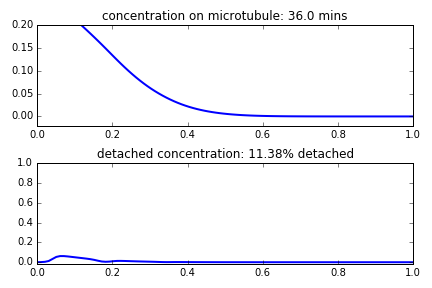
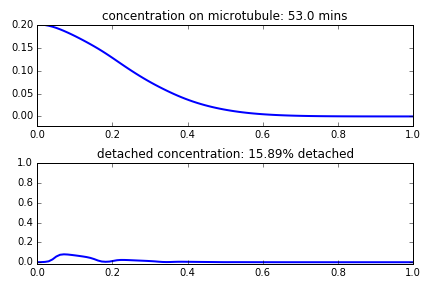
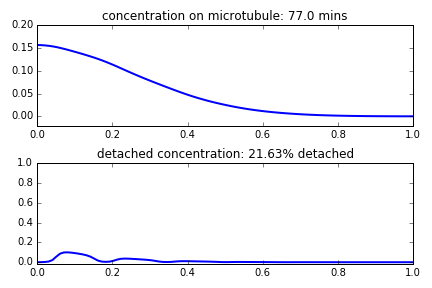
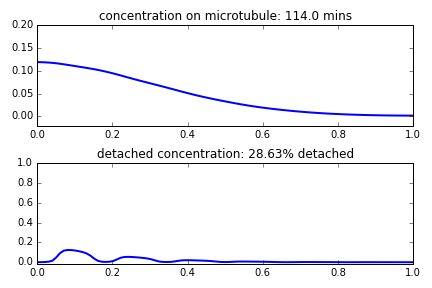
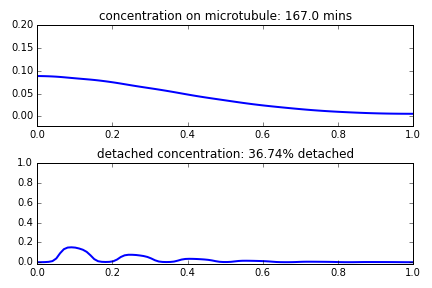
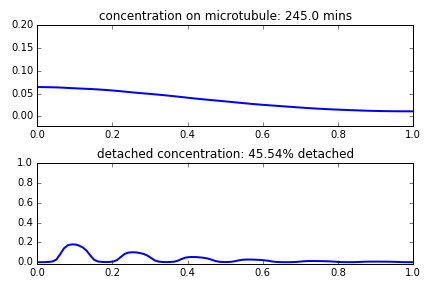
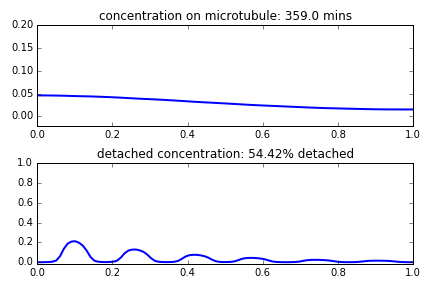
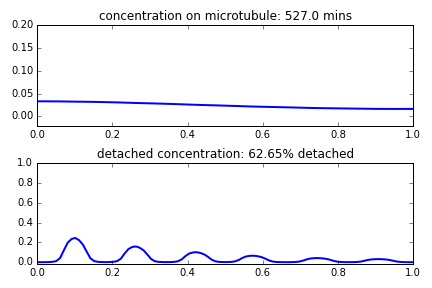
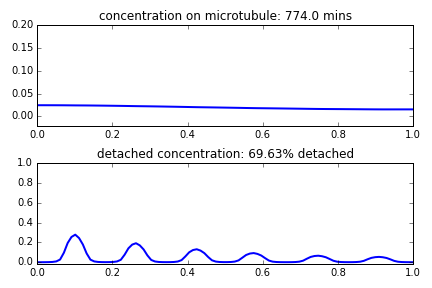
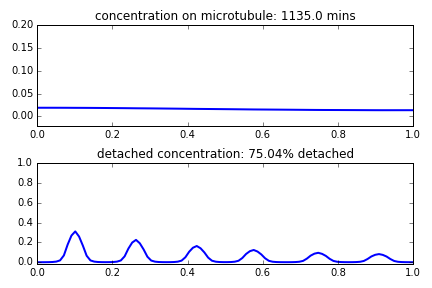
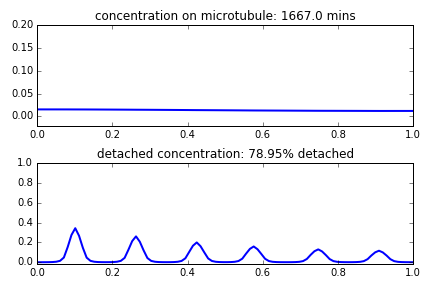
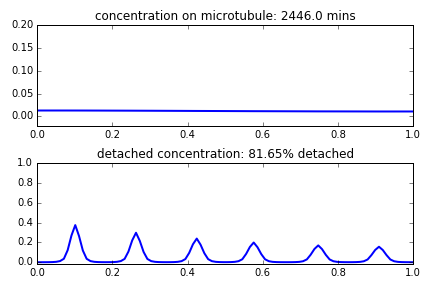
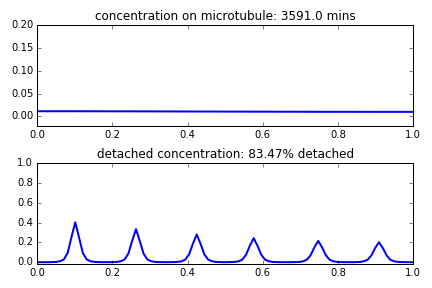
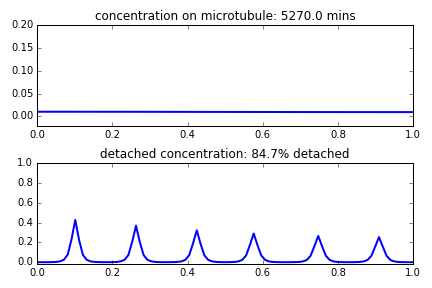
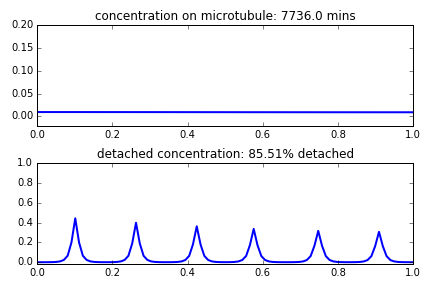
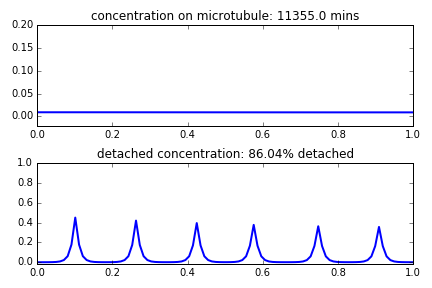
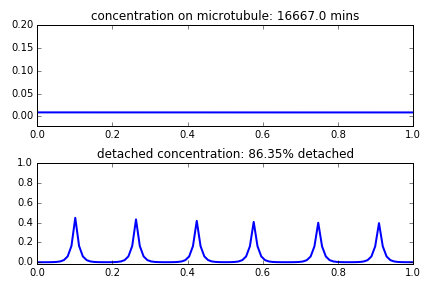
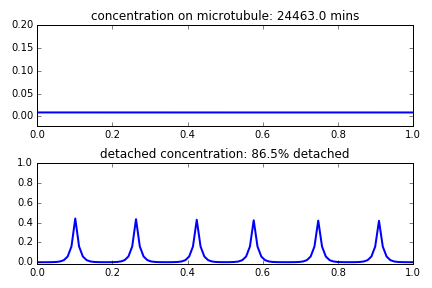
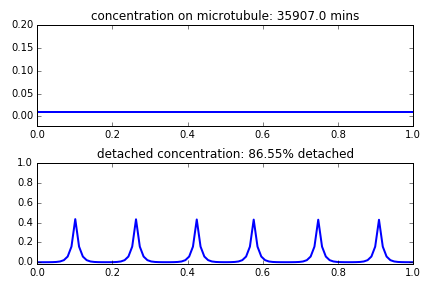
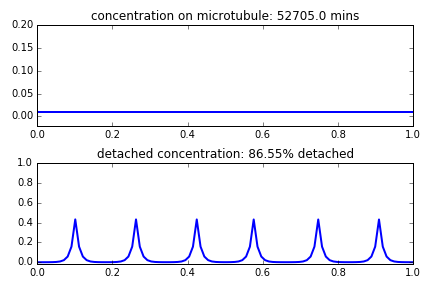

In [5]:
fig,animate,init = sim(1e-4,1e-6,np.logspace(0,6.5,nt))
ani3 = animation.FuncAnimation(fig, animate, init_func=init, frames=nt, interval=100)
ani3

# Tradeoff curves

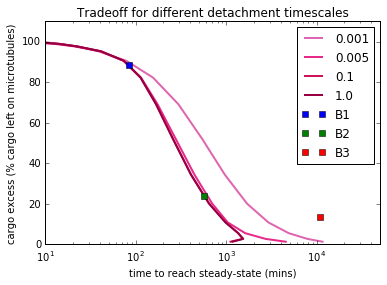

In [6]:
y = get_target_profile(6)
plt.figure()
dtch = [0.001, 0.005, 0.1, 1.0]
for cs,col in zip(dtch,['#df65b0','#e7298a','#ce1256','#980043']):
    tau,excess = calc_tradeoff_curve(y,cs)
    plt.plot(tau/60,excess*100,'-',color=col,lw=2)
for cs,ds,col in [(2e-1,1e-1,'b'), (1e-1,2e-3,'g'), (1e-4,1e-6,'r')]:
    A,u0 = get_matrix(y,cs,ds)
    tss,uss = calc_time_to_ss(A)
    excess = np.sum(uss[:N])/np.sum(uss)
    plt.plot(tss/60,excess*100,'s',color=col)
plt.ylim([0,110.0])
plt.xlim([1e1,5e4])
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('time to reach steady-state (mins)')
plt.ylabel('cargo excess (% cargo left on microtubules)')
plt.title('Tradeoff for different detachment timescales')
plt.legend(dtch+['B1','B2','B3'])
plt.show()

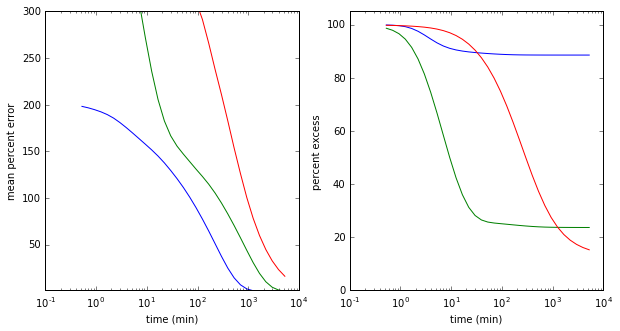

In [7]:
plt.figure(figsize=(10,5))

for cs,ds in [(2e-1,1e-1), (1e-1,2e-3), (1e-4,1e-6)]:
    t,err,excess = err_vs_time(cs,ds)
    plt.subplot(1,2,1)
    l = plt.plot(t/60,err,'-')
    plt.subplot(1,2,2)
    plt.plot(t/60,excess,'-')

plt.subplot(1,2,1)
yl = plt.ylim()
plt.ylim([1,300])
plt.xscale('log')
plt.xlabel('time (min)')
plt.ylabel('mean percent error')
plt.subplot(1,2,2)
plt.ylim([10,105])
plt.xscale('log')
yl = plt.ylim()
plt.ylim([0,yl[1]])
plt.xlabel('time (min)')
plt.ylabel('percent excess')
plt.show()